In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import yfinance as yf
from datetime import timedelta

df = yf.download('ETH-USD', start='2021-01-01', end='2021-12-31')
price = df['Close']

[*********************100%***********************]  1 of 1 completed


In [74]:
X = price.values
datesX = price.index
size = int(len(X) * 0.70)
train, test = X[:size], X[size:]
plotDates = datesX[size:]


def difference(dataset, interval=1):
    diff = []
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)

def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

days_in_year = 90
differenced = difference(train, days_in_year)

In [75]:
model = ARIMA(differenced, order=(2, 1, 1))
model_fit = model.fit()


df_actual = yf.download('ETH-USD', start='2022-01-01', end='2022-07-01')
actual_values = df_actual['Close'].values
actual_dates = df_actual.index
forecast_length = len(actual_values)


forecast = model_fit.predict(start=len(differenced), end=len(differenced) + forecast_length - 1)





[*********************100%***********************]  1 of 1 completed


Test RMSE: 1805.581


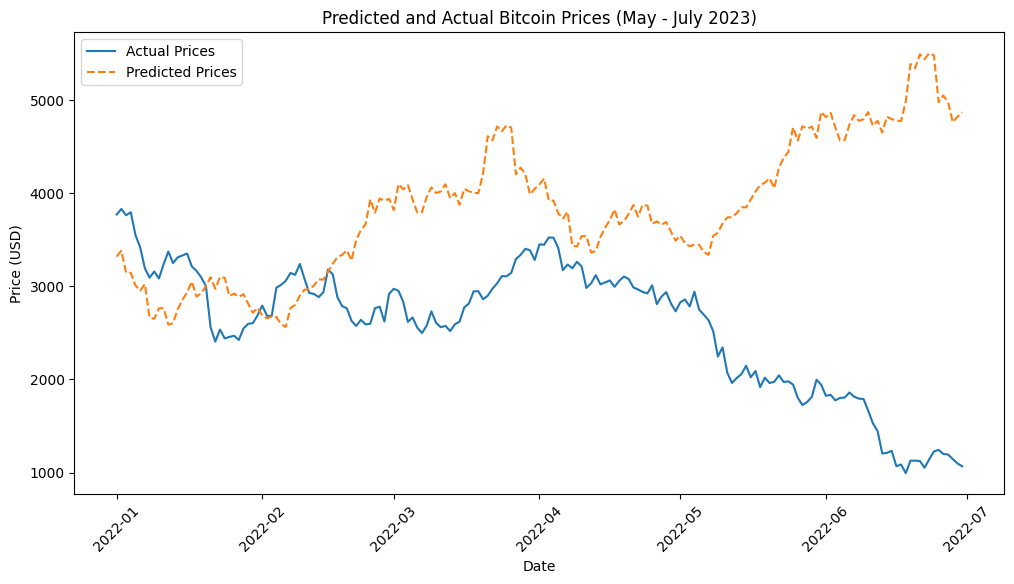

In [76]:
history = [x for x in train]
predicted_results = []
for yhat in forecast:
    inverted = inverse_difference(history, yhat, days_in_year)
    history.append(inverted)
    predicted_results.append(inverted)

predicted_results = predicted_results[:len(actual_values)]

rmse = np.sqrt(mean_squared_error(actual_values, predicted_results))
print(f'Test RMSE: {rmse:.3f}')

plt.figure(figsize=(12, 6))
plt.plot(actual_dates, actual_values, label='Actual Prices')
plt.plot(actual_dates, predicted_results, label='Predicted Prices', linestyle='--')
plt.ylabel('Price (USD)')
plt.xlabel('Date')
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.title('Predicted and Actual Bitcoin Prices (May - July 2023)')
plt.show()